# Week 2 lab: Markov-Chain Monte Carlo

## Goal

Gain a better understanding of what's going on under the hood in MCMC, so you'll be better at diagnosing and fixing computational problems when they occur (and they *will* occur).

## The plan

1. Simulate some data from a polynomial with noise
* Define a model for a Bayesian polynomial regression
* Implement Metropolis-Hastings from scratch, like your grandparents did
  * We've provided basic derivations for all the quantities you'll need to compute
  * We've laid out the functions you'll need to write- each one shouldn't be more than 10 or so lines
  * For each function, we've written a unit test you can run. It won't ensure your code is completely right, but it'll make sure it's at least outputting the right types of things
* Critically evaluate your MH outputs to see if you can get a reasonable answer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

## Synthetic data

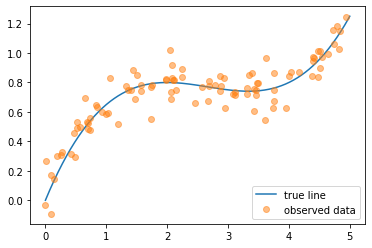

In [2]:
# synthetic polynomial data
xvals = np.linspace(0,5,1000)
coefs = np.array([1, -0.4, 0.05])
yvals = coefs[0]*xvals + coefs[1]*xvals**2 + coefs[2]*xvals**3

np.random.seed(1)
N = 100
x = np.random.uniform(0, 5, size=N)
y = coefs[0]*x + coefs[1]*x**2 + coefs[2]*x**3 + np.random.normal(0, 0.1, size=N)


plt.plot(xvals, yvals, label="true line")
plt.plot(x, y, "o", label="observed data", alpha=0.5)
plt.legend(loc="lower right");

## The model

Here's a simple model we could use (that happens to also be the one the data was generated by). Our predictions $\hat{y}$ are from a polynomial:

$\hat{y}_{i} = \theta_{1}x_{i} + \theta_{2}x_{i}^{2} + \theta_{3}x_{i}^{3}$

Where we place a normally-distributed prior over each of the $\theta$s,

$\theta_{j} \sim N(0, \sigma_{j}^{2})$

and we expect the actual values are normally distributed (with standard deviation 1) around the prediction:

$y_{i} \sim N(\hat{y}, 1)$

### What else would we include in a "real" regression model?

I left a couple things out of this example problem for simplicity. Generally we'd have:

* a parameter for the intercept
* a parameter for the variance around the prediction, instead of assuming that it's 1

### Hyperparameters

We'll need to specify three hyperparameters- the standard deviations of the prior for each of the three regression coefficients:

In [3]:
hyperparams = np.array([5,5,5])

## Coding up Metropolis-Hastings

### Refresher: what does MH do?

Start with some value for our parameters $\theta_{0}$. Each iteration $t$,

1. Sample a **candidate value** $\theta^{'}$ near $\theta_{t}$
2. Compute $f(\theta)$ for both $\theta_{t}$ and $\theta^{'}$, where $f$ is some function $f(\theta) \propto P(\theta|y)$
3. Compute the **acceptance ratio** $\alpha = f(\theta^{'})/f(\theta_{t})$
4. Sample a random number on the unit interval, $u \sim Uniform(0,1)$
5. Decide whether to accept or reject. 

  * If $u \le \alpha$: **accept**; $\theta_{t+1}=\theta^{'}$
  * If $u \gt \alpha$: **reject**; $\theta_{t+1}=\theta_{t}$


### The plan

We're drawing samples from a function

$P(\theta|y) \propto P(y|\theta)P(\theta)$

So for the MH accept/reject decision we need to compute $P(y|\theta)P(\theta)$ for each proposed value of our regression parameters $\theta$. Since the MH acceptance depends on a ratio,

$\alpha = \frac{P(y|\theta^{'})P(\theta^{'})}{P(y|\theta)P(\theta)}$

we can ignore any proportionality constants. It's also generally useful, when computing with probabilities, to use logarithms so that we don't get rounding errors for values close to zero. So what we'll actually compute (remembering that $\log[a/b] = \log[a]-\log[b]$) is

$\log[\alpha] = \log[P(y|\theta^{'})P(\theta^{'})] - \log[P(y|\theta)P(\theta)]$

### Prior

The prior is a normal distribution,

$P(\theta) = P(\theta_{1})P(\theta_{2})P(\theta_{3}) \propto \prod_{j=1}^{3}exp\left(-\frac{1}{2} \left(\frac{\theta_{j}}{\sigma_{j}}\right)^{2} \right)$

where each $\sigma_{j}$ is the prior hyperparameter for the $j$th parameter. By making any of the hyperparameters smaller, we can encode prior knowledge that that parameter should be close to zero. Our unnormalized log probability is

$\log[P(\theta)] = -\sum_{j=1}^{3}\frac{1}{2} \left(\frac{\theta_{j}}{\sigma_{j}}\right)^{2} $


### Likelihood

The likelihood is also a normal distribution (of $y$ this time). If we define $\hat{y}_{i}(\theta)$ to be the prediction for observation $i$ and parameters $\theta$, then (since we've set the variance to one)

$P(x|\theta) = \prod_{i=1}^{N}P(y_{i}|\theta) \propto \prod_{i}exp\left(-\frac{1}{2} (y_{i} - \hat{y}_{i}(\theta))^{2} \right)$

So the unnormallized log likelihood is

$\log[P(x|\theta)] = -\sum_{i=1}^{N} \frac{1}{2} (y_{i} - \hat{y}_{i}(\theta))^{2} $

### Putting it all together

Every MH update, you'll decide to accept or reject based on whether $\log[u]$ is greater or less than

$-\sum_{i=1}^{N} \frac{1}{2} (y_{i} - \hat{y}_{i}(\theta))^{2} -\sum_{j=1}^{3}\frac{1}{2} \left(\frac{\theta_{j}}{\sigma_{j}}\right)^{2}$

### Your mission

* write a function `pred()` that inputs a value of $\theta$ and returns predictions $\hat{y}_{i}(\theta)$ for all $i$
* write a function `log_prob()` that inputs a value of $\theta$ and returns the unnormalized log probability. It will need to call `pred()` to compute the likelihood
* write a function `metropolis_hastings_update()` that inputs a value of $\theta$ and a jump distance, and returns three things:
  * the next value of $\theta$
  * the corresponding log-probability (which we'll use to tune our burn-in)
  * a Boolean that's `True` if this was an acceptance or `False` if it was a rejection (which we'll use to tune the jump distance)
  
A couple things you may need:

* `np.random.normal(0,jump_distance,3)` to generate a Gaussian hop for a 3D array
* `np.random.uniform(0,1)` to generate a random number on the unit interval

In [4]:
def pred(theta):
    """
    Input array of coeffecients; output array of predicted y-hat values
    """
    return theta[0]*x + theta[1]*x**2 + theta[2]*x**3

In [5]:
def test_pred_correct_value():
    # unit test for pred()
    # does it give right answers for trivial cases?
    assert (pred(np.array([1,0,0])) == x).all()
    assert (pred(np.array([0,1,0])) == x**2).all()
    assert (pred(np.array([0,0,1])) == x**3).all()

In [6]:
test_pred_correct_value()

In [7]:
def log_prob(theta):
    """
    Input a value for the coeffecients and return the (unnormalized) log-probability.
    """
    return -0.5*np.sum((pred(theta)-y)**2) - 0.5*np.sum((theta/hyperparams)**2)

In [8]:
def test_log_prob():
    # unit test for log_prob
    # does it return the right type of thing?
    th = np.array([1,1,1])
    assert isinstance(log_prob(th), float)
    # test an obvious case
    assert log_prob(np.array([100,100,100])) < log_prob(np.array([0,0,0]))

In [9]:
test_log_prob()

In [10]:
def metropolis_hastings_update(theta, jump_distance):
    """
    Perform an update step for Metropolis hastings.
    
    :theta: numpy array of initial parameters
    :jump_distance: standard deviation of normal distribution for
        sampling candidate values
        
    Returns
        -New value of theta
        -Corresponding unnormalized log-probability
        -Boolean indicating whether this was an acceptance (True) or rejection (False)
    """
    # sample a candidate value for theta
    theta_prime = theta + np.random.normal(0, jump_distance, 3)
    # compute log probs
    old_prob = log_prob(theta)
    new_prob = log_prob(theta_prime)
    # compute log acceptance ratio
    log_acceptance_ratio = new_prob - old_prob
    # sample our acceptance threshold
    u = np.random.uniform(0,1)
    # accept
    if np.log(u) <= log_acceptance_ratio:
        return theta_prime, new_prob, True
    # reject
    else:
        return theta, old_prob, False

In [11]:
def test_metropolis_hastings_update():
    # just make sure it runs and outputs the right types of stuff
    th, p, a = metropolis_hastings_update(np.zeros(3), 1e-3)
    assert isinstance(th, np.ndarray)
    assert len(th) == 3
    assert isinstance(p, float)
    assert isinstance(a, bool)

In [12]:
test_metropolis_hastings_update()

## Now wrap it up and put a bow on it

Finally, write a function to manage the boring details of actually running MCMC:

* input a starting value for $\theta$ and any sampling parameters
* run MCMC
* manage and return the parameter values at every iteration, the log probability, and acceptance ratio

#### If you want to be fancy

Use `tqdm` to add a progress bar. Usage looks like this:

```
from tqdm import tqdm

for n in tqdm(range(N)):
    # stuff here
```

In [13]:
def metropolis_hastings(N=10000, init=np.zeros(3), jump_dist=5e-3):
    """
    Generate MCMC samples for our model
    
    :N: number of iterations
    :init: 3-dimensional numpy array of initial values
    :jump_dist: standard deviation of normal distribution used for candidate generation
    
    Returns
        -thetas: (N,3) array of parameter samples
        -probs: (N,) array of log-probabilities
        -acceptance_ratio: float; fraction of candidates accepted
    """
    thetas = np.zeros((N,3))
    probs = np.zeros((N,))
    accepts = 0
    theta = init
    
    for n in tqdm(range(N)):
        theta, l, a = metropolis_hastings_update(theta, jump_dist)
        thetas[n,:] = theta
        probs[n] = l
        accepts += int(a)
        
    return thetas, probs, accepts/N

In [14]:
def test_metropolis_hastings():
    # unit test- just make sure MH runs and gives right output types
    th, l, a = metropolis_hastings(1)
    assert isinstance(th, np.ndarray)
    assert th.shape == (1,3)
    assert isinstance(l, np.ndarray)
    assert l.shape == (1,)
    assert isinstance(a, float)

In [15]:
test_metropolis_hastings()

100%|██████████| 1/1 [00:00<00:00, 655.36it/s]


## Run inference and examine results

You can use the rest of this lab to experiment with your very own bespoke MCMC sampler. Below are some steps we can take to interpret the outputs of the sampler; try running under different configurations to see how good you can get your results!

In [16]:
thetas, probs, AR = metropolis_hastings(100000, jump_dist=1e-2)

100%|██████████| 100000/100000 [00:07<00:00, 13863.33it/s]


### Acceptance ratio

The **acceptance ratio** (fraction of proposals that were accepted) gives us some intuition for how to set `jump_dist`. If `AR` is close to 0, then it means we're wasting a lot of time testing impractical proposals and just reiterating the same values- so we should be taking smaller steps.

If `AR` is close to 1, it probably means we're taking steps that are too small and we're not fully exploring the parameter space.

Gelman says to aim for around 0.23.\*


\**WEAK CONVERGENCE AND OPTIMAL SCALING OF RANDOM WALK METROPOLIS ALGORITHMS* by Roberts, Gelman and Gilks, The Annals of Applied Probability 1997, Vol. 7, No. 1, 110-120).

In [17]:
AR

0.24671

### Log-probability

If we don't put much thought into initialization (and we didn't), the sampler might take a while to converge- the initial samples could be far from the actual posterior distribution. The log-probability can give us some insight into how many samples we should prune:

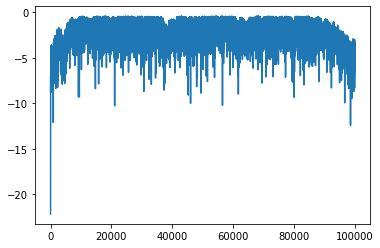

In [18]:
plt.plot(probs);

### Parameter values

It's always a good idea to plot the values of the different parameters "over time":

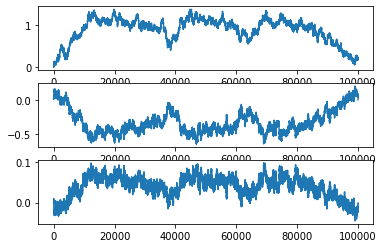

In [19]:
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(thetas[:,i])

#### Aside: what are we looking for?

Metropolis Hastings (if everything's working right) *asymptotically* converges to the distribution being simulated. If we're in (or close to) that asymptote, the samples should look like independent draws from a stationary distribution; if not, they'll be autocorrelated.

Let's compare a stationary distribution (IID draws from normal distribution) with an autocorrelated distribution (a Gaussian random walk):

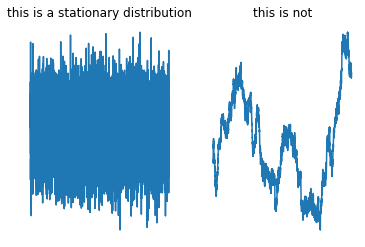

In [20]:
samples_from_a_distribution = np.random.normal(0,1,10000)
random_walk = samples_from_a_distribution.cumsum()

plt.subplot(121)
plt.plot(samples_from_a_distribution)
plt.title("this is a stationary distribution")
plt.axis("off")
plt.subplot(122)
plt.title("this is not")
plt.plot(random_walk)
plt.axis("off");

We can also look at the autocorrelation directly:

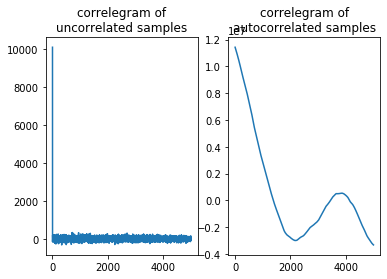

In [21]:
N = len(samples_from_a_distribution)
plt.subplot(121)
plt.title("correlegram of\nuncorrelated samples")
plt.plot(np.correlate(samples_from_a_distribution, samples_from_a_distribution, "same")[int(N/2):])
plt.subplot(122)
plt.title("correlegram of\nautocorrelated samples")
plt.plot(np.correlate(random_walk, random_walk, "same")[int(N/2):]);

Back to the outputs of our MCMC sampler- how do they look?

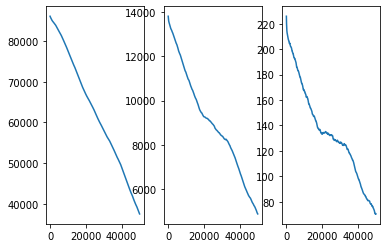

In [22]:
N = thetas.shape[0]

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(np.correlate(thetas[:,i], thetas[:,i], "same")[int(N/2):])

We have some options for how to address this:

* specify a "burn-in" phase where we discard the first samples (look at the log-prob plot to see how long this phase should be)
* "thin" the samples to make them less autocorrelated by keeping only every $n$th sample
* adjust sampling parameters
* collect more samples (but please make sure you have some options handy other than "brute force")
* check for correlations between parameters; you may need a different sampling algorithm
* put more thought into how we choose our initial parameter values- in more complicated models poor initialization can completely prevent the model from converging
* most importantly: **consider adjusting your model.** Remember the....

### Folk theorem of statistical computing

*When you have computational problems, often there's a problem with your model* (Gelman)

### Burn-in and thinning:

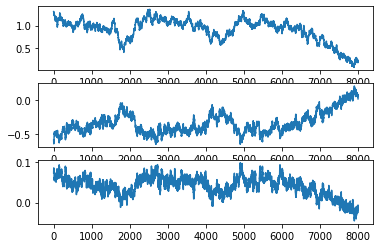

In [23]:
burnin = 20000
thin = 10

for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(thetas[burnin::thin,i])

Plotting a histogram of the sampled values will give a picture of the marginal posterior of each parameter:

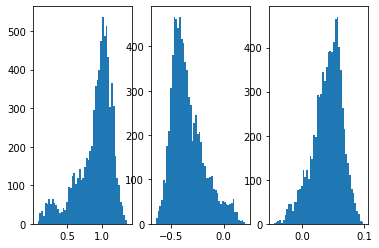

In [24]:
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(thetas[burnin::thin,i], bins=50);

We can use a few scatter plots to visualize any correlations between the parameters:

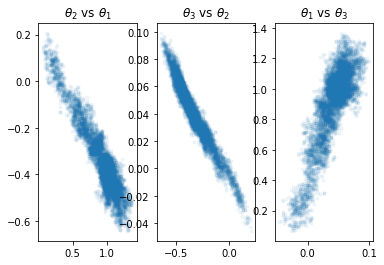

In [25]:
burnin = 20000
thin = 10
for i in range(3):
    plt.subplot(1,3,i+1)
    j = (i+1)%3
    plt.plot(thetas[burnin::thin,i], thetas[burnin::thin,(i+1)%3], ".", alpha=0.05)
    plt.title("$\\theta_{%s}$ vs $\\theta_{%s}$"%(j+1,i+1));

Even though the **priors** for our parameters are independent, the **posteriors** are highly correlated- conditioning on our data has added an interaction between all of them. So choosing a particular value for $\theta_{1}$ changes the maximum-posterior values for $\theta_{2}$ and $\theta_{3}$.

Notice that our implementation of MH didn't take these correlations into account anywhere- when we propose a new value for the parameters, it's guessing randomly in parameter space even though an increase to $\theta_{1}$ should generally mean a decrease in $\theta_{2}$. More-sophisticated MCMC samplers (like HMC and NUTS) will sample more efficiently by factoring in these relationships.

### Yes, but does it work?

How close we need our samples to being "truly stationary" will depend on the application- even with our current rough-around-the-edges Markov chain, we can check to see whether it's learning the basic structure of our data and faithfully representing uncertainty:

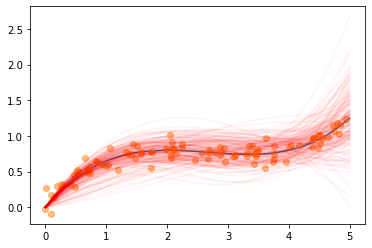

In [26]:
plt.plot(xvals, yvals, label="true line")
plt.plot(x, y, "o", label="observed data", alpha=0.5)

for i in list(range(len(probs)))[burnin::500][:250]:
    y_post = thetas[i,0]*xvals + thetas[i,1]*xvals**2 + thetas[i,2]*xvals**3
    plt.plot(xvals, y_post, "r", alpha=0.05)